In [1]:
# Standard modules
import numpy as np
import nibabel as nib
#import dipy.viz.regtools as rt
import reg_utils.regviz as rv
from dipy.align import VerbosityLevels
from dipy.align.transforms import regtransforms
from dipy.align.imaffine import (AffineMap,
                                 transform_centers_of_mass,
                                 MutualInformationMetric,
                                 AffineRegistration)
# Our modules
from dataset_info.info import get_neobrain
import pickle
import os
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 10)

def load_nib(fname):
    img_nib = nib.load(fname)
    img = img_nib.get_data().squeeze()
    img_affine = img_nib.get_affine()
    return img, img_affine

def dipy_align(static, static_grid2world, moving, moving_grid2world,
               transforms=None, level_iters=None, prealign=None):
    r''' Full rigid registration with Dipy's imaffine module

    Here we implement an extra optimization heuristic: move the geometric
    centers of the images to the origin. Imaffine does not do this by default
    because we want to give the user as much control of the optimization
    process as possible.

    '''
    # Bring the center of the moving image to the origin
    c_moving = tuple(0.5 * np.array(moving.shape, dtype=np.float64))
    c_moving = moving_grid2world.dot(c_moving+(1,))
    correction_moving = np.eye(4, dtype=np.float64)
    correction_moving[:3,3] = -1 * c_moving[:3]
    centered_moving_aff = correction_moving.dot(moving_grid2world)

    # Bring the center of the static image to the origin
    c_static = tuple(0.5 * np.array(static.shape, dtype=np.float64))
    c_static = static_grid2world.dot(c_static+(1,))
    correction_static = np.eye(4, dtype=np.float64)
    correction_static[:3,3] = -1 * c_static[:3]
    centered_static_aff = correction_static.dot(static_grid2world)

    dim = len(static.shape)
    metric = MutualInformationMetric(nbins=32, sampling_proportion=0.3)
    #metric = LocalCCMetric(radius=4)
    #metric.verbosity = VerbosityLevels.DEBUG

    # Registration schedule: center-of-mass then translation, then rigid and then affine
    if prealign is None:
        prealign = 'mass'

    if transforms is None:
        transforms = ['TRANSLATION', 'RIGID', 'AFFINE']
    
    nlevels = len(transforms)
    if level_iters is None:
        level_iters = [[10000, 1000, 100]] * nlevels

    sol = np.eye(dim + 1)
    for i in range(nlevels):
        transform_name = transforms[i]
        affr = AffineRegistration(metric=metric, level_iters=level_iters[i])
        affr.verbosity = VerbosityLevels.DEBUG        
        
        
        transform = regtransforms[(transform_name, dim)]
        print('Optimizing: %s'%(transform_name,))
        x0 = None
        sol = affr.optimize(static, moving, transform, x0,
                              centered_static_aff, centered_moving_aff, starting_affine = prealign)
        prealign = sol.affine.copy()

    # Now bring the geometric centers back to their original location
    fixed = np.linalg.inv(correction_moving).dot(sol.affine.dot(correction_static))
    sol.set_affine(fixed)
    sol.domain_grid2world = static_grid2world
    sol.codomain_grid2world = moving_grid2world

    return sol

Populating the interactive namespace from numpy and matplotlib


In [2]:
t1_fname = get_neobrain('train', 2, 'T1')
t2_fname = get_neobrain('train', 2, 'T2')

t1, t1_affine = load_nib(t1_fname)
t2, t2_affine = load_nib(t2_fname)

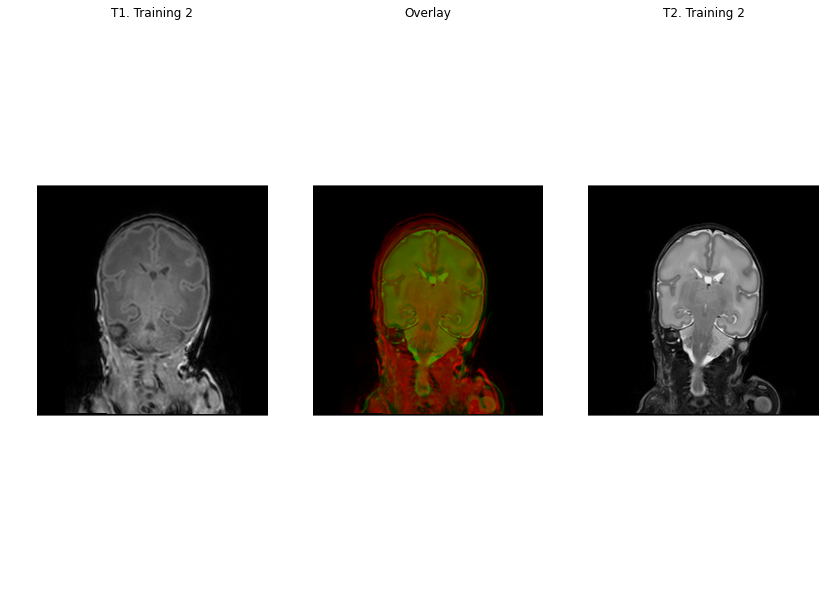

In [7]:
# Show images in grid space (without resampling)
rv.overlay_slices(t1, t2, slice_type=2, ltitle='T1. Training 2', rtitle='T2. Training 2', flip_vertical=True);

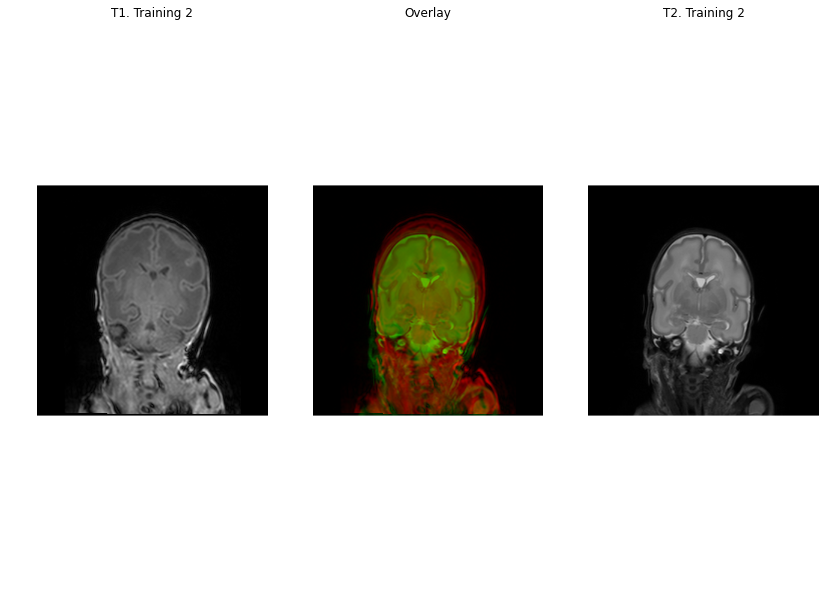

In [8]:
# Show overlap in physical space (apparently it is better not to use the grid-to-world transforms)
id_aff = AffineMap(None, t1.shape, t1_affine, t2.shape, t2_affine)
t2_resampled = id_aff.transform(t2)
# Probably, the grid-to-world transforms are wrong (?)
rv.overlay_slices(t1, t2_resampled, slice_type=2, ltitle='T1. Training 2', rtitle='T2. Training 2', flip_vertical=True);

In [9]:
aff_name = 'intrasubject_train1_t2_towards_t1.p'
if os.path.isfile(aff_name):
    aff = pickle.load(open(aff_name, 'r'))
else:
    aff = dipy_align(t1, t1_affine, t2, t2_affine, transforms=['RIGID'], prealign=np.eye(4))
    pickle.dump(aff, open(aff_name,'w'))

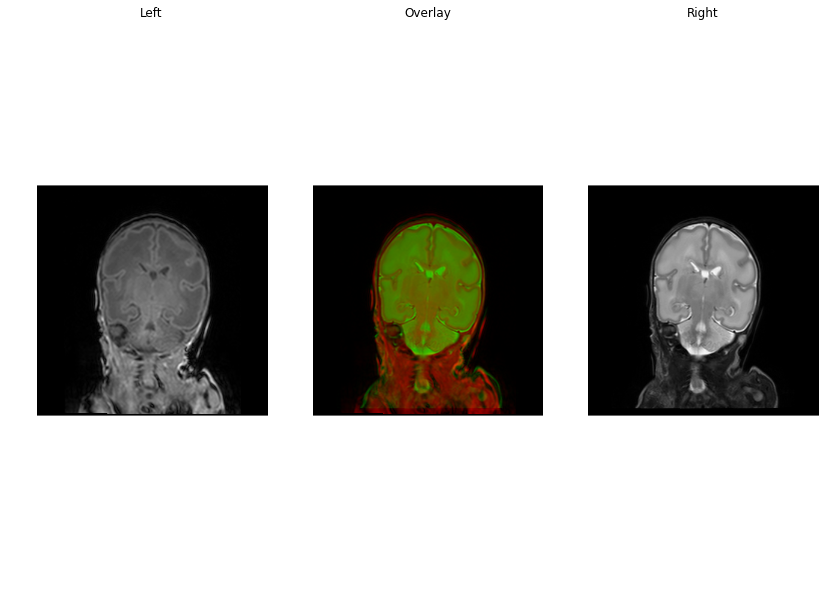

In [10]:
t2_aligned = aff.transform(t2)
rv.overlay_slices(t1, t2_aligned, slice_type=2, flip_vertical=True);

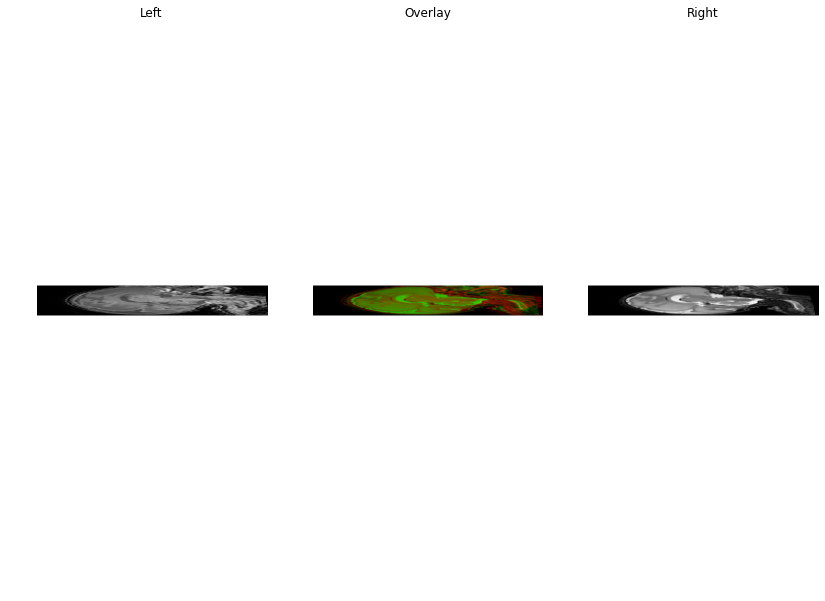

In [12]:
rv.overlay_slices(t1, t2_aligned, slice_type=0, flip_vertical=True);